In [11]:
with open("gwyfile_test_gwy.gwy", "rb") as f:
    print(f.read(1000))

b'GWYPGwyContainer\x00\\\xda\x02\x01/0/data\x00oGwyDataField\x00\x85\x00 \x00xres\x00i\x00\x02\x00\x00yres\x00i\x00\x02\x00\x00xreal\x00d\xfc\x1f5\x94\x16\x19\x9d>yreal\x00d\xfc\x1f5\x94\x16\x19\x9d>si_unit_xy\x00oGwySIUnit\x00\x0b\x00\x00\x00unitstr\x00sm\x00si_unit_z\x00oGwySIUnit\x00\x0b\x00\x00\x00unitstr\x00sm\x00data\x00D\x00\x00\x04\x00;\x01V\xd1\xa8\xd1\x81>bQ\x97\xb3\xf0\xd0\x81>\x16Z\xadW2\xcd\x81>\x16Z\xadW2\xcd\x81>\x94B\x1c.\xdb\xd0\x81>\xb15\xed\xe0\xb3\xd7\x81>\x05\x04\x16R/\xce\x81>\xd6\xc7\xb9\x7f\xff\xcd\x81>i\x0e\x13\xe6\xfa\xcf\x81>N;W\xad\xd1\xc6\x81>\x1a\xc3\xda\xd1\x0f\xc4\x81>L\xbf\xdf\xa4[\xcf\x81><\xe9\x7f\xf28\xc4\x81>Ug\',\x10\xc8\x81>XDCs\xc1\xc9\x81>\xcd\x18Z\x1a)\xce\x81>/g\x16(\x18\xc9\x81>c\xe6\xaa\xe1\xfb\xd2\x81>O3/\xe8\'\xc6\x81>\xa6\x87?\xd3\xf2\xc5\x81>~HrQ\x96\xd0\x81>\t\xdcMx\xde\xca\x81>o\x16\x0e\xa0\x1f\xd7\x81>\x84-\x17\xd4\xe9\xbe\x81>\xc7\xec\x89\x9b\xea\xcc\x81>/\xda>\xae\xc6\xd6\x81>\xf7\xfb\xd8\xfc\xce\xd8\x81>\x04\xb6- \x0f\xdf\x81>fez})

In [98]:
import io
import struct
import numpy as np
import matplotlib.pyplot as plt

indentation = 0
image_data = {}

def log(txt):
    """Custom logging wrapper to allow for multi-level
    indentation based on the depth of objects and components."""
    indents = "  " * indentation
    print(indents + str(txt))


def read_until_null(f: io.TextIOWrapper) -> str:
    byte = f.read(1).decode('ascii')
    value = ""
    while byte != '\x00':
        value += byte
        byte = f.read(1).decode('ascii')
    return str(value)

def read_u32i(f: io.TextIOWrapper) -> str:
    return int(struct.unpack('<i', f.read(4))[0])

def read_8d(f: io.TextIOWrapper) -> str:
    return str(struct.unpack('d', f.read(8))[0])

def read_dtype(f: io.TextIOWrapper) -> str:
    return f.read(1).decode('ascii')

def read_object(f: io.TextIOWrapper):
    global indentation
    global image_data
    indentation += 1

    # Read name
    name = read_until_null(f)
    data_size = int(read_u32i(f))
    log(f'OBJECT | name: {name} | data_size: {data_size}')

    # Read component
    # Repeatedly read components until data size is used up
    read_data_size = 0
    while read_data_size < data_size:
        component_data_size = read_component(f, f.tell())
        read_data_size += component_data_size

    indentation -= 1

def read_component(f: io.TextIOWrapper, initial_byte_pos: int):
    global indentation
    global image_data
    indentation += 1

    name = read_until_null(f)
    dtype = read_dtype(f)

    if dtype == 'c':
        value = f.read(1).decode('ascii')
        log(f"component name: {name} | dtype: {dtype} | value: {value}")
        image_data[name] = value
    elif dtype == 'i':
        value = read_u32i(f)
        log(f"component name: {name} | dtype: {dtype} | value: {value}")
        image_data[name] = value
    elif dtype == 'd':
        value = read_8d(f)
        log(f"component name: {name} | dtype: {dtype} | value: {value}")
        image_data[name] = value
    elif dtype == 's':
        value = read_until_null(f)
        log(f"component name: {name} | dtype: {dtype} | value: {value}")
        image_data[name] = value
    elif dtype == 'D':
        # Found the data. Read it.
        arr_size = read_u32i(f)
        log(f'component name: {name} | dtype: {dtype} |')
        log(f'arr_size: {arr_size}')
        data = np.zeros(image_data['xres'] * image_data['yres'])
        for i in range(image_data['xres'] * image_data['yres']):
            # Read next 8 bytes as double and assign
            binary_num = f.read(8)
            double_num = struct.unpack('<d', binary_num)[0]
            data[i] = double_num
        image_data['data'] = data.reshape((image_data['xres'], image_data['yres']))

    if dtype == 'o':
        log(f'component name: {name} | dtype: {dtype} |')
        read_object(f)
    
    indentation -= 1
    return f.tell() - initial_byte_pos


with open("gwyfile_test_gwy.gwy", "rb") as f:
    # Read header
    log(f.read(4))
    # Read Gwycontainer and size
    read_object(f)

print(f'image data size: {len(image_data)}')




b'GWYP'
  OBJECT | name: GwyContainer | data_size: 16964188
    component name: /0/data | dtype: o |
      OBJECT | name: GwyDataField | data_size: 2097285
        component name: xres | dtype: i | value: 512
        component name: yres | dtype: i | value: 512
        component name: xreal | dtype: d | value: 4.3359399999999874e-07
        component name: yreal | dtype: d | value: 4.3359399999999874e-07
        component name: si_unit_xy | dtype: o |
          OBJECT | name: GwySIUnit | data_size: 11
            component name: unitstr | dtype: s | value: m
        component name: si_unit_z | dtype: o |
          OBJECT | name: GwySIUnit | data_size: 11
            component name: unitstr | dtype: s | value: m
        component name: data | dtype: D |
        arr_size: 262144
    component name: /0/data/log | dtype: o |
      OBJECT | name: GwyStringList | data_size: 180
    component name: 0/data/title | dtype: s | value: ZSensor
    component name: /0/data/view/relative-size | dtype

'\x00' seems common, is it a thing to split data chunks?

\x00 null terminator - SO says used for parsing etc

In [45]:
import struct

with open("gwyfile_test_gwy.gwy", "rb") as f:

    for i in range(200):
        f.seek(i)

        four_bytes = f.read(4)

        # f.read(1)
        # Offsets

        if four_bytes == b'xres':
            print(f"'{str(four_bytes)}' at position {i}")
            xres_offset = i
            break
    else:
        print('unbroken')

    f.seek(xres_offset - 10)
    print(f.read(50))

    for i in range(200):
        f.seek(xres_offset + i)
        eight_bytes = f.read(4)


        int_num = struct.unpack('<i', eight_bytes[:4])[0]
        string = struct.unpack('4s', eight_bytes)[0].decode()

        print(f"int32:{int_num} str:{string} bytes:{eight_bytes}")

# 'b'xres'' at position 47
# eight_bytes: 1936028280
# eight_bytes: 7562610
# eight_bytes: 1761637221
# eight_bytes: 6881395
# eight_bytes: 33581312
# eight_bytes: 131177
# eight_bytes: 512       <---------- HERE IS THE SIZE


# xres\x00i\x00\x02\x00\x00yres\x00i\x00\x02\x00\x0
# the i is the datatype
# the \x00\x02\x00\x00 is 512 in little endian

'b'xres'' at position 47
b'Field\x00\x85\x00 \x00xres\x00i\x00\x02\x00\x00yres\x00i\x00\x02\x00\x00xreal\x00d\xfc\x1f5\x94\x16\x19\x9d>yreal'
int32:1936028280 str:xres bytes:b'xres'
int32:7562610 str:res  bytes:b'res\x00'
int32:1761637221 str:es i bytes:b'es\x00i'
int32:6881395 str:s i  bytes:b's\x00i\x00'
int32:33581312 str: i  bytes:b'\x00i\x00\x02'
int32:131177 str:i   bytes:b'i\x00\x02\x00'
int32:512 str:    bytes:b'\x00\x02\x00\x00'
int32:2030043138 str:  y bytes:b'\x02\x00\x00y'
int32:1920532480 str:  yr bytes:b'\x00\x00yr'
int32:1702000896 str: yre bytes:b'\x00yre'
int32:1936028281 str:yres bytes:b'yres'
int32:7562610 str:res  bytes:b'res\x00'
int32:1761637221 str:es i bytes:b'es\x00i'
int32:6881395 str:s i  bytes:b's\x00i\x00'
int32:33581312 str: i  bytes:b'\x00i\x00\x02'
int32:131177 str:i   bytes:b'i\x00\x02\x00'
int32:512 str:    bytes:b'\x00\x02\x00\x00'
int32:2013265922 str:  x bytes:b'\x02\x00\x00x'
int32:1920466944 str:  xr bytes:b'\x00\x00xr'
int32:1702000640 st

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 3: invalid start byte

In [53]:
with open("gwyfile_test_gwy.gwy", "rb") as f:
    chunks = f.read(1000).split(b'\x00')
    for chunk in chunks:
        pstring = ""
        pstring += f"{chunk}"
        try:
            pstring += f"   {struct.unpack('<i', chunk[:4])[0]}"
        except: 
            pass
        print(pstring)

b'GWYPGwyContainer'   1348032327
b'\\\xda\x02\x01/0/data'   16964188
b'oGwyDataField'   2037860207
b'\x85'
b' '
b'xres'   1936028280
b'i'
b'\x02'
b''
b'yres'   1936028281
b'i'
b'\x02'
b''
b'xreal'   1634038392
b'd\xfc\x1f5\x94\x16\x19\x9d>yreal'   891288676
b'd\xfc\x1f5\x94\x16\x19\x9d>si_unit_xy'   891288676
b'oGwySIUnit'   2037860207
b'\x0b'
b''
b''
b'unitstr'   1953066613
b'sm'
b'si_unit_z'   1969187187
b'oGwySIUnit'   2037860207
b'\x0b'
b''
b''
b'unitstr'   1953066613
b'sm'
b'data'   1635017060
b'D'
b''
b'\x04'
b";\x01V\xd1\xa8\xd1\x81>bQ\x97\xb3\xf0\xd0\x81>\x16Z\xadW2\xcd\x81>\x16Z\xadW2\xcd\x81>\x94B\x1c.\xdb\xd0\x81>\xb15\xed\xe0\xb3\xd7\x81>\x05\x04\x16R/\xce\x81>\xd6\xc7\xb9\x7f\xff\xcd\x81>i\x0e\x13\xe6\xfa\xcf\x81>N;W\xad\xd1\xc6\x81>\x1a\xc3\xda\xd1\x0f\xc4\x81>L\xbf\xdf\xa4[\xcf\x81><\xe9\x7f\xf28\xc4\x81>Ug',\x10\xc8\x81>XDCs\xc1\xc9\x81>\xcd\x18Z\x1a)\xce\x81>/g\x16(\x18\xc9\x81>c\xe6\xaa\xe1\xfb\xd2\x81>O3/\xe8'\xc6\x81>\xa6\x87?\xd3\xf2\xc5\x81>~HrQ\x96\xd0\x81>\t\xdc

In [136]:
with open("gwyfile_test_gwy.gwy", "rb") as f:

    print(f.read(1000).split(b'\x00'))

[b'GWYPGwyContainer', b'\\\xda\x02\x01/0/data', b'oGwyDataField', b'\x85', b' ', b'xres', b'i', b'\x02', b'', b'yres', b'i', b'\x02', b'', b'xreal', b'd\xfc\x1f5\x94\x16\x19\x9d>yreal', b'd\xfc\x1f5\x94\x16\x19\x9d>si_unit_xy', b'oGwySIUnit', b'\x0b', b'', b'', b'unitstr', b'sm', b'si_unit_z', b'oGwySIUnit', b'\x0b', b'', b'', b'unitstr', b'sm', b'data', b'D', b'', b'\x04', b";\x01V\xd1\xa8\xd1\x81>bQ\x97\xb3\xf0\xd0\x81>\x16Z\xadW2\xcd\x81>\x16Z\xadW2\xcd\x81>\x94B\x1c.\xdb\xd0\x81>\xb15\xed\xe0\xb3\xd7\x81>\x05\x04\x16R/\xce\x81>\xd6\xc7\xb9\x7f\xff\xcd\x81>i\x0e\x13\xe6\xfa\xcf\x81>N;W\xad\xd1\xc6\x81>\x1a\xc3\xda\xd1\x0f\xc4\x81>L\xbf\xdf\xa4[\xcf\x81><\xe9\x7f\xf28\xc4\x81>Ug',\x10\xc8\x81>XDCs\xc1\xc9\x81>\xcd\x18Z\x1a)\xce\x81>/g\x16(\x18\xc9\x81>c\xe6\xaa\xe1\xfb\xd2\x81>O3/\xe8'\xc6\x81>\xa6\x87?\xd3\xf2\xc5\x81>~HrQ\x96\xd0\x81>\t\xdcMx\xde\xca\x81>o\x16\x0e\xa0\x1f\xd7\x81>\x84-\x17\xd4\xe9\xbe\x81>\xc7\xec\x89\x9b\xea\xcc\x81>/\xda>\xae\xc6\xd6\x81>\xf7\xfb\xd8\xfc\xce\xd8\

there's meant to be size data after 'D' but no clue what '\x04' means. tried converting to binary, ASCII, hex etc, no sensible numbers come out

data probably in mess of escape code thingies after the 'D'

In [18]:
dat = rb'\xd5'
# string = bytes.fromhex(dat)
string = dat.decode('unicode_escape')
print(f'[{string}]')

[Õ]


In [59]:
chunk = b'\x00\x02\x00\x00'
print(f"{struct.unpack('<i', chunk[:4])[0]}")

512


In [83]:
import struct

# 8-byte binary number
# binary_num = b';\\x01V\\x'# 9.419762536525321e-23
# binary_num = b'd1\\xa8\\x'# 4.2939554967867245e+174
binary_num = b'\\x01V\\xd' # 2.8129534125733946e+137

#  '>d' format to convert to double
double_num = struct.unpack('>d', binary_num)[0]

print(double_num)

2.8129534125733946e+137


In [42]:
import struct

binary_string = "000101110011110001100001100100"
num = int(binary_string, 2)
little_endian_binary = struct.pack("<I", num)
little_endian_num, = struct.unpack("<i", little_endian_binary)
print(little_endian_num)

97458276


In [29]:
import numpy as np

f = open("gwyfile_test_gwy.gwy", "r")
a = np.fromfile(f, dtype=np.uint32)
print(a[0:32])


[1348032327 1132033863 1635020399 1919250025   47864832  791686913
 1635017060 2001170176 1952531577 1701398113 2231395436 2013274112
    7562610     131177 1702000896    6881395 2013265922 1818322290
  536634368  420910133 1920548509    7102821  891288676 2635667092
 1600746302 1953066613    7960671 2037860207 1851083091  184579177
 1962934272 1937009006]


In [18]:
with open("gwyfile_test_gwy.gwy", "rb") as f:

    # find 'D' then start spitting out data formatted as doubles?

    byte = None
    while byte != b'D':
        byte = f.read(1)
        # print(f'{byte} {byte==b"D"}')
    print(byte)
    
    # split_bytes = bytes.split(b'\x00')

    # for expr in split_bytes:
    #     print(expr)


    _ = f.read(2)
    # Offsets
    # 0 : random?
    # 1 : 0 -> 3k???? wtf? no afm file should have that data range but the data is so much more sense
    # making than the other offsets. defo double prec though. what could be different?
    # 2 : random
    # 3 : random
    # 4 : random
    # 5 : random
    # 6 : random
    # 7 : random?


    # Offsets ========== LITTLE ENDIAN ==========
    # 0 : e-302 ish
    # 1 : random
    # 2 : typically e-6 to e-10 - strangely consistent given randomness of others...
    # 3 : random
    # 4 : random
    # 5 : random
    # 6 : random
    # 7 : random


    for i in range(1000000):
        # Read next 8 bytes as double and print:
        binary_num = f.read(8)

        # HECK
        # LITTLE ENDIAN - USE < 
        # THE NUMBERS WERE THE WRONG WAY
        double_num = struct.unpack('<d', binary_num)[0]

        if i % 10000 == 0:
            # multiply by 1e9 since it seems is in nm??
            print(f'{double_num * 1e9} : {i+1}')

# shift in number type between 260k and 270k, end of data is somewhere in this range
# 5.702570564363982 : 250001
# 6066.0498366571455 : 260001
# -1.0718301450783044e+108 : 270001
# -2.6249704448517207e+191 : 280001

# The consistently ~ 0-10k numbers cease at 8-byte-set number ~260k, sqrt of 260k is ~ 500
# 500x500 pixels seems correct for the data? What's going on with the strange fluctuating magnitudes?



b'D'
-1.3779499496898298e-275 : 1
130.65120124421583 : 10001
132.28968680606184 : 20001
130.06011345763537 : 30001
131.6004102080112 : 40001
130.3711525038748 : 50001
130.6781680627616 : 60001
129.04435815860467 : 70001
130.36582467584927 : 80001
128.95606502293188 : 90001
129.8434574796812 : 100001
130.26268829202206 : 110001
129.27031181252002 : 120001
127.20781197072691 : 130001
128.40238249786387 : 140001
127.02230881017194 : 150001
130.09909550557202 : 160001
126.76291974267984 : 170001
128.03338792043024 : 180001
131.08886277264494 : 190001
127.34362272571057 : 200001
128.50959600846062 : 210001
126.88051752574297 : 220001
130.52968884588395 : 230001
126.92091278643642 : 240001
127.34971212723975 : 250001
126.05222349152663 : 260001
-1.4667608870299358e+155 : 270001
-4.397581026335095e+161 : 280001
1.9964911131026643e-308 : 290001
-1.453658210154752e+116 : 300001
-4.4671846275539604e+174 : 310001
-4.6693577776754124e+135 : 320001
-4.3975810341326936e+161 : 330001
-7.7364570730130

HECK if I use little-endian then I get values all ~ 130! :D

In [168]:
with open("gwyfile_test_gwy.gwy", "rb") as f:

    # find 'D' then start spitting out data formatted as doubles?

    byte = None
    while byte != b'D':
        byte = f.read(1)

    print(byte)
    
    # split_bytes = bytes.split(b'\x00')

    # for expr in split_bytes:
    #     print(expr)

    _ = f.read(2 + 18 * 8)
    # Offsets
    # 0 - random
    # 1 - random
    # 2 - VERY close to ~130
    # 3 - random
    # 4 - random
    # 5 - random
    # 6 - random
    # 7 - random

    # find how big this data array is
    i = 0
    while True:
        binary_num = f.read(8)
        double_num = struct.unpack('<d', binary_num)[0]
        if abs(double_num * 1e9 - 132) > 10:
            print(double_num * 1e9 - 132)
            break
        i += 1
        if i < 10:
            print(double_num*1e9)
    
    print(i)
    print(np.sqrt(i))


    for i in range(5):
        # Read next 8 bytes as double and print:
        binary_num = f.read(8)
        # Use the '>d' format to convert to double
        double_num = struct.unpack('<d', binary_num)[0]

        print(f'{double_num * 1e9} : {i+1}')

# FUCK YES


b'D'
132.76176306573907
132.74083147822216
132.63187866970043
132.63187866970043
132.7383847772938
132.9376435273313
132.6606389566715
132.65520225656215
132.71288693525503
-132.0
262144
512.0
1.2895584991237494e+286 : 1
1.6985842429633225e+208 : 2
8.739905738081695e+254 : 3
6.702173060108142e+100 : 4
3.684213873911248e+189 : 5


In [5]:
# numpy time

import numpy as np
import struct

data = np.zeros(512**2)

with open("gwyfile_test_gwy.gwy", "rb") as f:
    byte = None
    while byte != b'D':
        byte = f.read(1)

    # Skip to data
    dump = f.read(2)
    print(dump)
    print()
    dump = f.read(18*8)
    print(dump)

    for i in range(512**2):
        # Read next 8 bytes as double and print:
        binary_num = f.read(8)
        # Use the '>d' format to convert to double
        double_num = struct.unpack('<d', binary_num)[0]

        # print(f'{double_num * 1e9} : {i+1}')
        data[i] = double_num

data = data.reshape((512, 512))

b'at'

b'aField\x00\x85\x00 \x00xres\x00i\x00\x02\x00\x00yres\x00i\x00\x02\x00\x00xreal\x00d\xfc\x1f5\x94\x16\x19\x9d>yreal\x00d\xfc\x1f5\x94\x16\x19\x9d>si_unit_xy\x00oGwySIUnit\x00\x0b\x00\x00\x00unitstr\x00sm\x00si_unit_z\x00oGwySIUnit\x00\x0b\x00\x00\x00unitstr\x00sm\x00data\x00D\x00\x00\x04\x00'


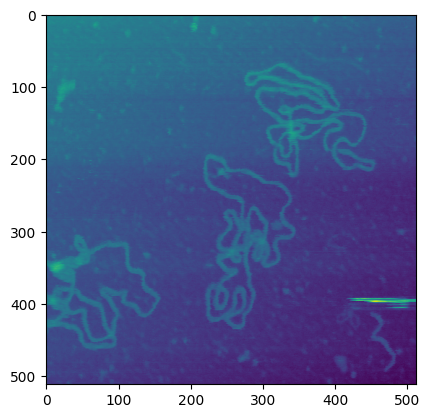

In [10]:
import matplotlib.pyplot as plt

plt.imshow(data)
plt.show()

# 🎉